In [48]:
import pandas as pd
import numpy as np

In [49]:
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

# Data can also be saved locally and read from local drive
# url_confirmed = 'time_series_covid19_confirmed_global.csv'
# url_deaths = 'time_series_covid19_deaths_global.csv'
# url_recovered = 'time_series_covid19_recovered_global.csv'

df_confirmed = pd.read_csv(url_confirmed)
df_deaths = pd.read_csv(url_deaths)
df_recovered = pd.read_csv(url_recovered)

In [50]:
def df_move1st_sg(df_t):

    #Moving Singapore to the first row in the datatable
    df_t["new"] = range(1,len(df_t)+1)
    df_t.loc[df_t[df_t['Country/Region'] == 'Indonesia'].index.values,'new'] = 0
    df_t = df_t.sort_values("new").drop('new', axis=1)
    return df_t

In [51]:
#########################################################################################
# Data preprocessing for getting useful data and shaping data compatible to plotly plot
#########################################################################################

# Total cases
df_confirmed_total = df_confirmed.iloc[:, 4:].sum(axis=0)
df_deaths_total = df_deaths.iloc[:, 4:].sum(axis=0)
df_recovered_total = df_recovered.iloc[:, 4:].sum(axis=0)

# modified deaths dataset for mortality rate calculation
df_deaths_confirmed=df_deaths.copy()
df_deaths_confirmed['confirmed'] = df_confirmed.iloc[:,-1]

#Sorted - df_deaths_confirmed_sorted is different from others, as it is only modified later. Careful of it dataframe structure
df_deaths_confirmed_sorted = df_deaths_confirmed.sort_values(by=df_deaths_confirmed.columns[-2], ascending=False)[['Country/Region',df_deaths_confirmed.columns[-2],df_deaths_confirmed.columns[-1]]]
df_recovered_sorted = df_recovered.sort_values(by=df_recovered.columns[-1], ascending=False)[['Country/Region',df_recovered.columns[-1]]]
df_confirmed_sorted = df_confirmed.sort_values(by=df_confirmed.columns[-1], ascending=False)[['Country/Region',df_confirmed.columns[-1]]]

#Single day increase
df_deaths_confirmed_sorted['24hr'] = df_deaths_confirmed_sorted.iloc[:,-2] - df_deaths.sort_values(by=df_deaths.columns[-1], ascending=False)[df_deaths.columns[-2]]
df_recovered_sorted['24hr'] = df_recovered_sorted.iloc[:,-1] - df_recovered.sort_values(by=df_recovered.columns[-1], ascending=False)[df_recovered.columns[-2]]
df_confirmed_sorted['24hr'] = df_confirmed_sorted.iloc[:,-1] - df_confirmed.sort_values(by=df_confirmed.columns[-1], ascending=False)[df_confirmed.columns[-2]]

#Aggregate the countries with different province/state together
df_deaths_confirmed_sorted_total = df_deaths_confirmed_sorted.groupby('Country/Region').sum()
df_deaths_confirmed_sorted_total=df_deaths_confirmed_sorted_total.sort_values(by=df_deaths_confirmed_sorted_total.columns[0], ascending=False).reset_index()
df_recovered_sorted_total = df_recovered_sorted.groupby('Country/Region').sum()
df_recovered_sorted_total=df_recovered_sorted_total.sort_values(by=df_recovered_sorted_total.columns[0], ascending=False).reset_index()
df_confirmed_sorted_total = df_confirmed_sorted.groupby('Country/Region').sum()
df_confirmed_sorted_total=df_confirmed_sorted_total.sort_values(by=df_confirmed_sorted_total.columns[0], ascending=False).reset_index()

#Modified recovery csv due to difference in number of rows. Recovered will match ['Province/State','Country/Region']column with Confirmed ['Province/State','Country/Region']
df_recovered['Province+Country'] = df_recovered[['Province/State','Country/Region']].fillna('nann').agg('|'.join,axis=1)
df_confirmed['Province+Country'] = df_confirmed[['Province/State','Country/Region']].fillna('nann').agg('|'.join,axis=1)
df_recovered_fill = df_recovered
df_recovered_fill.set_index("Province+Country")
df_recovered_fill.set_index("Province+Country").reindex(df_confirmed['Province+Country'])
df_recovered_fill = df_recovered_fill.set_index("Province+Country").reindex(df_confirmed['Province+Country']).reset_index()

#split Province+Country back into its respective columns
new = df_recovered_fill["Province+Country"].str.split("|", n = 1, expand = True)
df_recovered_fill['Province/State']=new[0]
df_recovered_fill['Country/Region']=new[1]
df_recovered_fill['Province/State'].replace('nann','NaN')

#drop 'Province+Country' for all dataset
df_confirmed.drop('Province+Country',axis=1,inplace=True)
df_recovered.drop('Province+Country',axis=1,inplace=True)
df_recovered_fill.drop('Province+Country',axis=1,inplace=True)

# Data preprocessing for times series countries graph display 
# create temp to store sorting arrangement for all confirm, deaths and recovered.
df_confirmed_sort_temp = df_confirmed.sort_values(by=df_confirmed.columns[-1], ascending=False)

df_confirmed_t = df_move1st_sg(df_confirmed_sort_temp)
df_confirmed_t['Province+Country'] = df_confirmed_t[['Province/State','Country/Region']].fillna('nann').agg('|'.join,axis=1)
df_confirmed_t=df_confirmed_t.drop(['Province/State','Country/Region','Lat','Long'],axis=1).T

df_deaths_t = df_deaths.reindex(df_confirmed_sort_temp.index)
df_deaths_t = df_move1st_sg(df_deaths_t)
df_deaths_t['Province+Country'] = df_deaths_t[['Province/State','Country/Region']].fillna('nann').agg('|'.join,axis=1)
df_deaths_t=df_deaths_t.drop(['Province/State','Country/Region','Lat','Long'],axis=1).T

# take note use reovered_fill df
df_recovered_t = df_recovered_fill.reindex(df_confirmed_sort_temp.index)
df_recovered_t = df_move1st_sg(df_recovered_t)
df_recovered_t['Province+Country'] = df_recovered_t[['Province/State','Country/Region']].fillna('nann').agg('|'.join,axis=1)
df_recovered_t=df_recovered_t.drop(['Province/State','Country/Region','Lat','Long'],axis=1).T

df_confirmed_t.columns = df_confirmed_t.iloc[-1]
df_confirmed_t = df_confirmed_t.drop('Province+Country')

df_deaths_t.columns = df_deaths_t.iloc[-1]
df_deaths_t = df_deaths_t.drop('Province+Country')

df_recovered_t.columns = df_recovered_t.iloc[-1]
df_recovered_t = df_recovered_t.drop('Province+Country')

df_confirmed_t.index=pd.to_datetime(df_confirmed_t.index)
df_deaths_t.index=pd.to_datetime(df_confirmed_t.index)
df_recovered_t.index=pd.to_datetime(df_confirmed_t.index)

# Highest 10 plot data preprocessing
# getting highest 10 countries with confirmed case
name = df_confirmed_t.columns.str.split("|", 1)
df_confirmed_t_namechange=df_confirmed_t.copy()

# name0 = [x[0] for x in name]
name1 = [x[1] for x in name]
df_confirmed_t_namechange.columns = name1
df_confirmed_t_namechange=df_confirmed_t_namechange.groupby(df_confirmed_t_namechange.columns,axis=1).sum()
df_confirmed_t_namechange10 = df_confirmed_t_namechange.sort_values(by=df_confirmed_t_namechange.index[-1], axis=1, ascending=False).iloc[:,:10]
df_confirmed_t_stack = df_confirmed_t_namechange10.stack()
df_confirmed_t_stack=df_confirmed_t_stack.reset_index(level=[0,1])
df_confirmed_t_stack.rename(columns={"level_0": "Date",'level_1':'Countries', 0: "Confirmed"}, inplace=True)

# getting highest 10 countries with deceased case
name = df_deaths_t.columns.str.split("|", 1)
df_deaths_t_namechange=df_deaths_t.copy()

# name0 = [x[0] for x in name]
name1 = [x[1] for x in name]
df_deaths_t_namechange.columns = name1
df_deaths_t_namechange=df_deaths_t_namechange.groupby(df_deaths_t_namechange.columns,axis=1).sum()
df_deaths_t_namechange10 = df_deaths_t_namechange.sort_values(by=df_deaths_t_namechange.index[-1], axis=1, ascending=False).iloc[:,:10]
df_deaths_t_stack = df_deaths_t_namechange10.stack()
df_deaths_t_stack=df_deaths_t_stack.reset_index(level=[0,1])
df_deaths_t_stack.rename(columns={"level_0": "Date",'level_1':'Countries', 0: "Deceased"}, inplace=True)

In [52]:
def high_cases(countryname,total,single,color_word='#63b6ff',confirmed_total=1,deaths = False,):

    if deaths:

        percent = (total/confirmed_total)*100
        return html.P([ html.Span(countryname + ' | ' + f"{int(total):,d}",
                             style={'backgroundColor': colors['highest_case_bg'], 'borderRadius': '6px',}),
                    html.Span(' +' + f"{int(single):,d}",
                             style={'color': color_word,'margin':2,'fontWeight': 'bold','fontSize': 14,}),
                    html.Span(f' ({percent:.2f}%)',
                             style={'color': color_word,'margin':2,'fontWeight': 'bold','fontSize': 14,}),
                   ],
                  style={
                        'textAlign': 'center',
                        'color': 'rgb(200,200,200)',
                        'fontsize':12,
                        }       
                )

    return html.P([ html.Span(countryname + ' | ' + f"{int(total):,d}",
                        style={'backgroundColor': colors['highest_case_bg'], 'borderRadius': '6px',}),
            html.Span(' +' + f"{int(single):,d}",
                        style={'color': color_word,'margin':2,'fontWeight': 'bold','fontSize': 14,}),
            ],
            style={
                'textAlign': 'center',
                'color': 'rgb(200,200,200)',
                'fontsize':12,
                }       
        )


noToDisplay = 10

confirm_cases = []
for i in range(noToDisplay):
    confirm_cases.append(high_cases(df_confirmed_sorted_total.iloc[i,0],df_confirmed_sorted_total.iloc[i,1],df_confirmed_sorted_total.iloc[i,2]))


In [53]:
meninggal_data_baru = df_deaths_confirmed_sorted_total.head(noToDisplay)
meninggal_negara_nama = meninggal_data_baru.iloc[0:noToDisplay,0]
meninggal_negara_kasus = meninggal_data_baru.iloc[0:noToDisplay,1]
meninggal_negara_penambahan = meninggal_data_baru.iloc[0:noToDisplay,3]

In [54]:
meninggal_negara_penambahan

0    425
1    680
2     14
3     23
4     23
5      1
6    759
7    312
8    119
9      0
Name: 24hr, dtype: int64

In [55]:
df_confirmed_t = (df_confirmed_t - df_confirmed_t.shift(1)).drop(df_confirmed_t.index[0])
df_deaths_t = (df_deaths_t - df_deaths_t.shift(1)).drop(df_deaths_t.index[0])
df_recovered_t = (df_recovered_t - df_recovered_t.shift(1)).drop(df_recovered_t.index[0])

In [56]:
df_confirmed_total = df_confirmed.iloc[:, 4:].sum(axis=0)
df_confirmed

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,5639,6053,6402,6664,7072,7653,8145,8676,9216,9998,10582,11173,11831,12456,13036,13659,14525,15205,15750,16509,17267,18054,18969,19551,20342,20917,21459,22142,22890,23546,24102,24766,25527,26310,26874,27532,27878,28424,28833,29157
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,898,916,933,946,948,949,964,969,981,989,998,1004,1029,1050,1076,1099,1122,1137,1143,1164,1184,1197,1212,1232,1246,1263,1299,1341,1385,1416,1464,1521,1590,1672,1722,1788,1838,1891,1962,1995
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,6442,6629,6821,7019,7201,7377,7542,7728,7918,8113,8306,8503,8697,8857,8997,9134,9267,9394,9513,9626,9733,9831,9935,10050,10154,10265,10382,10484,10589,10698,10810,10919,11031,11147,11268,11385,11504,11631,11771,11920
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,761,761,761,761,761,761,762,762,762,762,762,763,763,763,763,764,764,764,765,844,851,852,852,852,852,852,852,852,852,853,853,853,853,854,854,855,855,855,855,855
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,48,48,48,48,50,52,52,58,60,61,69,70,70,71,74,81,84,86,86,86,86,86,86,88,91,92,96,113,118,130,138,140,142,148,155,166,172,176,183,186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,235,235,235,235,246,251,251,251,251,251,251,299,441,443,458,463,479,483,484,484,484,485,499,499,513,513,514,611,632,639,659,661,662,671,683,688,693,698,698,702
262,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,85,106,122,128,130,167,184,197,209,212,222,233,249,256,278,283,310,323,354,399,419,453,469,482,484,496,524,560,591,632,705,728,844,885,902,909,919,922,941,967
263,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,11,11,11,11,11,11,34,34,78,78,87,87,87,87,87,87,106,106,106,132,132,132,132,141,141,141,141,162,162,163,176,176,176,197,197,210,210,247,247,247
264,NaN,Tajikistan,38.861034,71.276093,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,907,1118,1322,1524,1729,1936,2140,2350,2551,2738,2929,3100,3266,3424,3563,3686,3807,3930,4013,4100,4191,4289,4370,4453,4529,4609,4690,4763,4834,4902,4971,5035,5097,5160,5221,5279,5338,5399,5457,5513


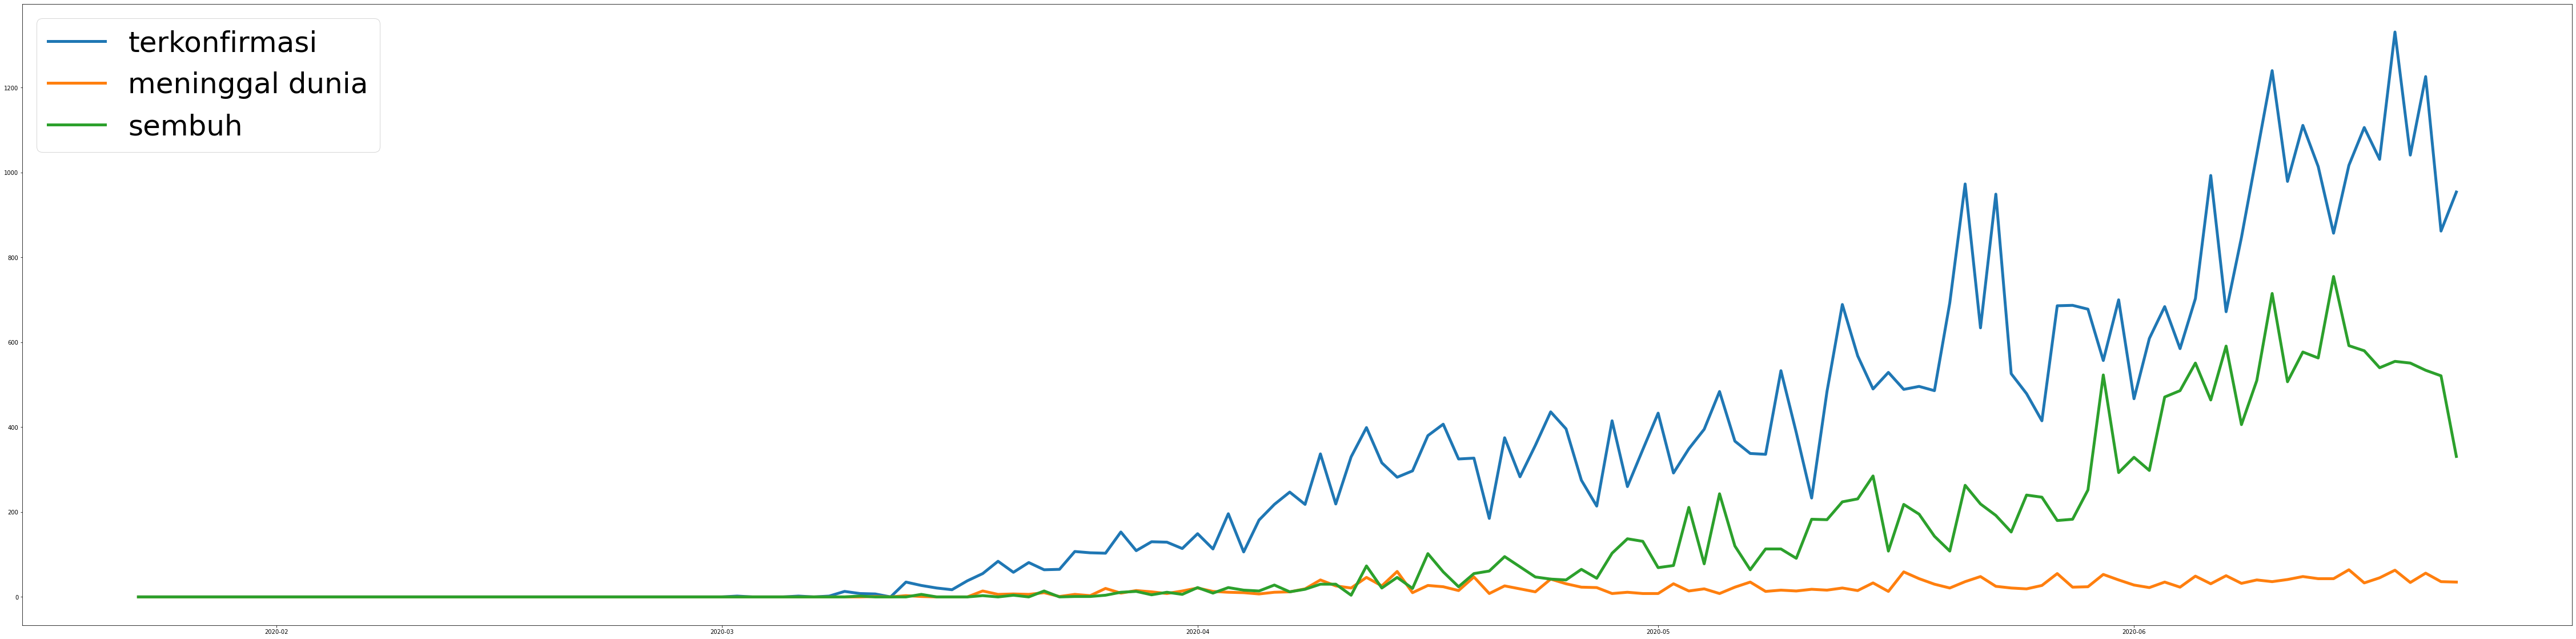

In [40]:
#GRAFIK PERKEMBANGAN COVID-19 HARIAN DI NEGARA TERTENTU
import matplotlib.pyplot as plt

x=df_confirmed_t.index
y1=df_confirmed_t.iloc[:, 0]
y2=df_deaths_t.iloc[:, 0]
y3=df_recovered_t.iloc[:, 0]

fig = plt.figure(figsize= (80,20))
plt.plot(x,y1, label='terkonfirmasi', linewidth=5)
plt.plot(x,y2, label='meninggal dunia', linewidth=5)
plt.plot(x,y3, label='sembuh', linewidth=5)

plt.legend(loc=2, fontsize=50)

In [41]:
y11 = df_confirmed_t.iloc[:, 0]
y11

2020-01-23       0
2020-01-24       0
2020-01-25       0
2020-01-26       0
2020-01-27       0
              ... 
2020-06-18    1331
2020-06-19    1041
2020-06-20    1226
2020-06-21     862
2020-06-22     954
Name: nann|Indonesia, Length: 152, dtype: object

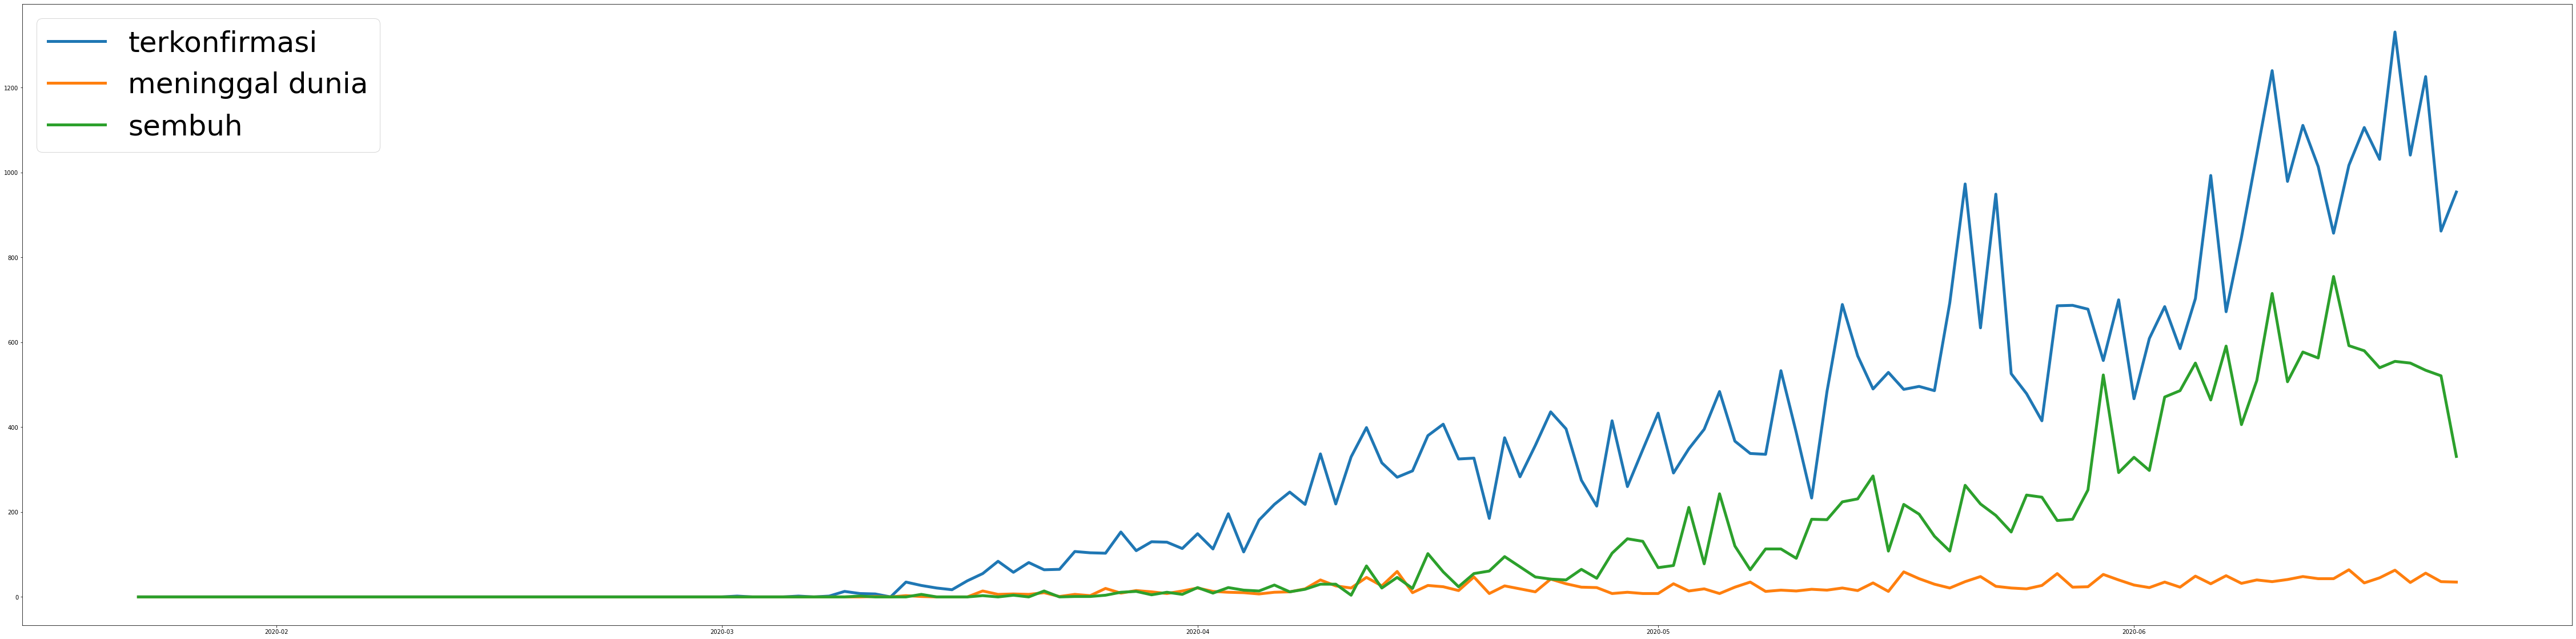

In [42]:
#GRAFIK PERKEMBANGAN COVID-19 TOTAL DI NEGARA TERTENTU
import matplotlib.pyplot as plt

x=df_confirmed_t.index
y1=df_confirmed_t.iloc[:, 0]
y2=df_deaths_t.iloc[:, 0]
y3=df_recovered_t.iloc[:, 0]

fig = plt.figure(figsize= (80,20))
plt.plot(x,y1, label='terkonfirmasi', linewidth=5)
plt.plot(x,y2, label='meninggal dunia', linewidth=5)
plt.plot(x,y3, label='sembuh', linewidth=5)

plt.legend(loc=2, fontsize=50)

In [43]:
df_confirmed_sorted

,Country/Region,6/22/20,24hr
225,US,2312302,31012
28,Brazil,1106470,23129
187,Russia,591465,7586
131,India,440215,14933
223,United Kingdom,305289,958
...,...,...,...
244,Canada,5,0
248,United Kingdom,3,0
78,China,1,0
258,France,1,0


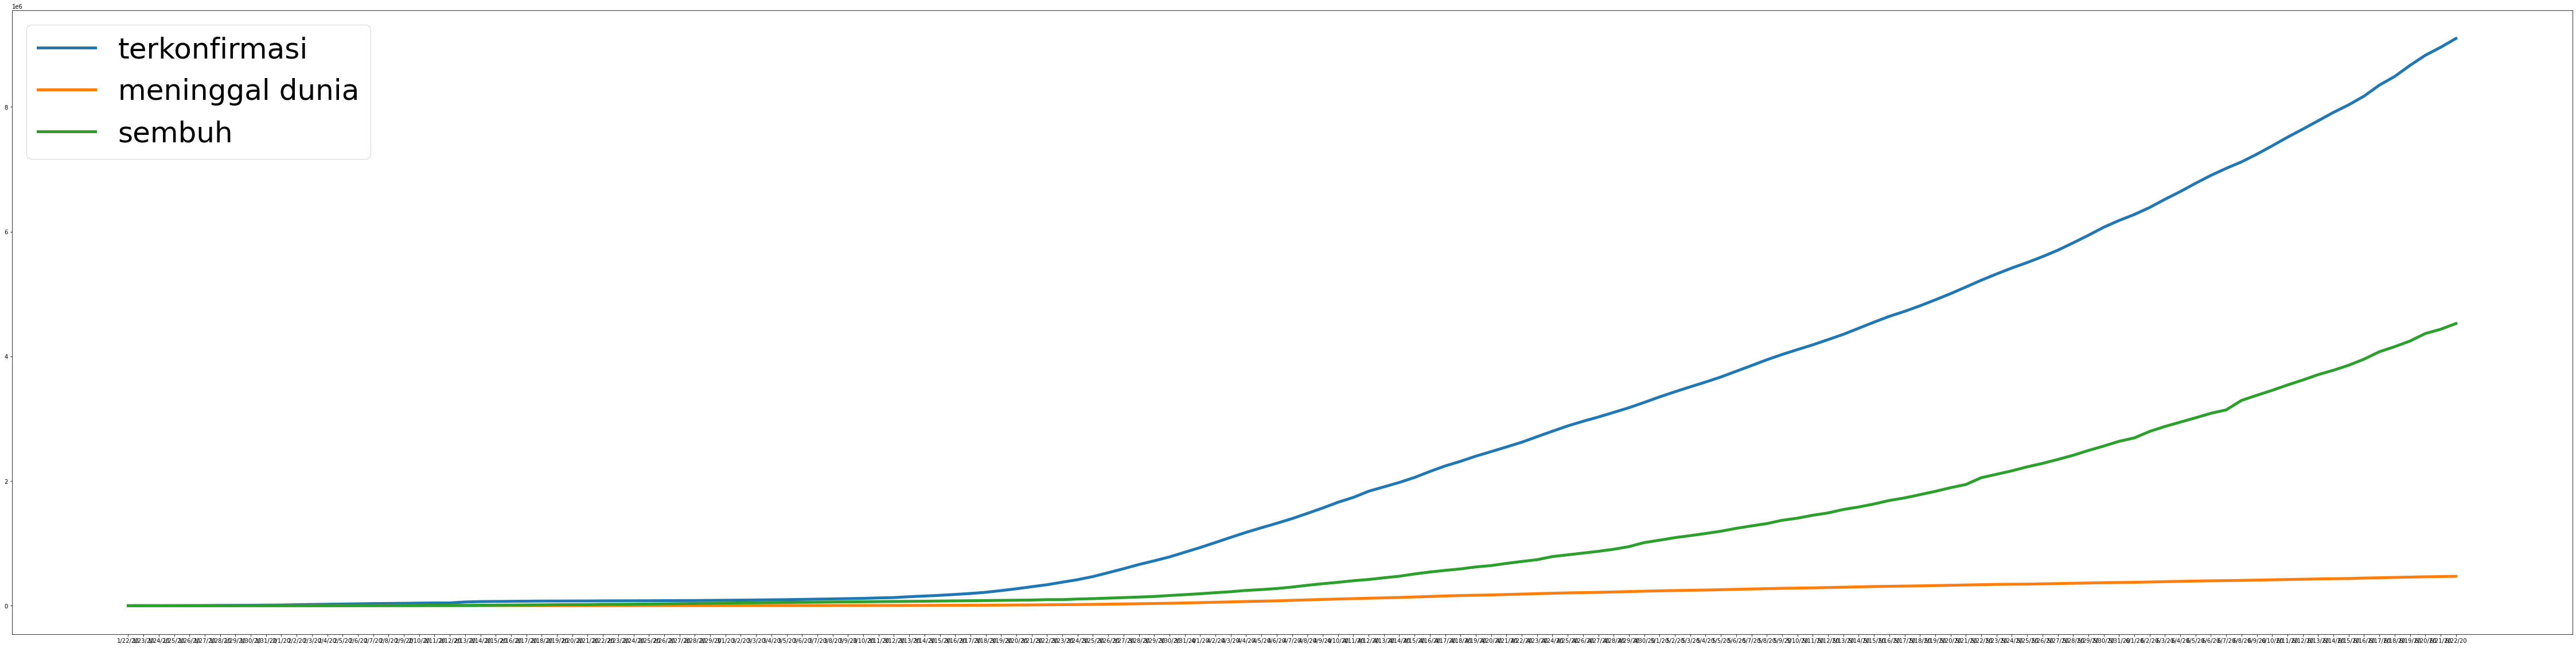

In [44]:
#GRAFIK PERKEMBANGAN COVID-19 DI DUNIA
import matplotlib.pyplot as plt

x=df_confirmed_total.index
y1=df_confirmed_total
y2=df_deaths_total
y3=df_recovered_total

fig = plt.figure(figsize= (80,20))
plt.plot(x,y1, label='terkonfirmasi', linewidth=5)
plt.plot(x,y2, label='meninggal dunia', linewidth=5)
plt.plot(x,y3, label='sembuh', linewidth=5)

plt.legend(loc=2, fontsize=50)
#plt.show()

In [45]:
df_confirmed_daily = (df_confirmed_total - df_confirmed_total.shift(1)).drop(df_confirmed_total.index[0])
df_deaths_daily = (df_deaths_total - df_deaths_total.shift(1)).drop(df_deaths_total.index[0])
df_recovered_daily = (df_recovered_total - df_recovered_total.shift(1)).drop(df_recovered_total.index[0])


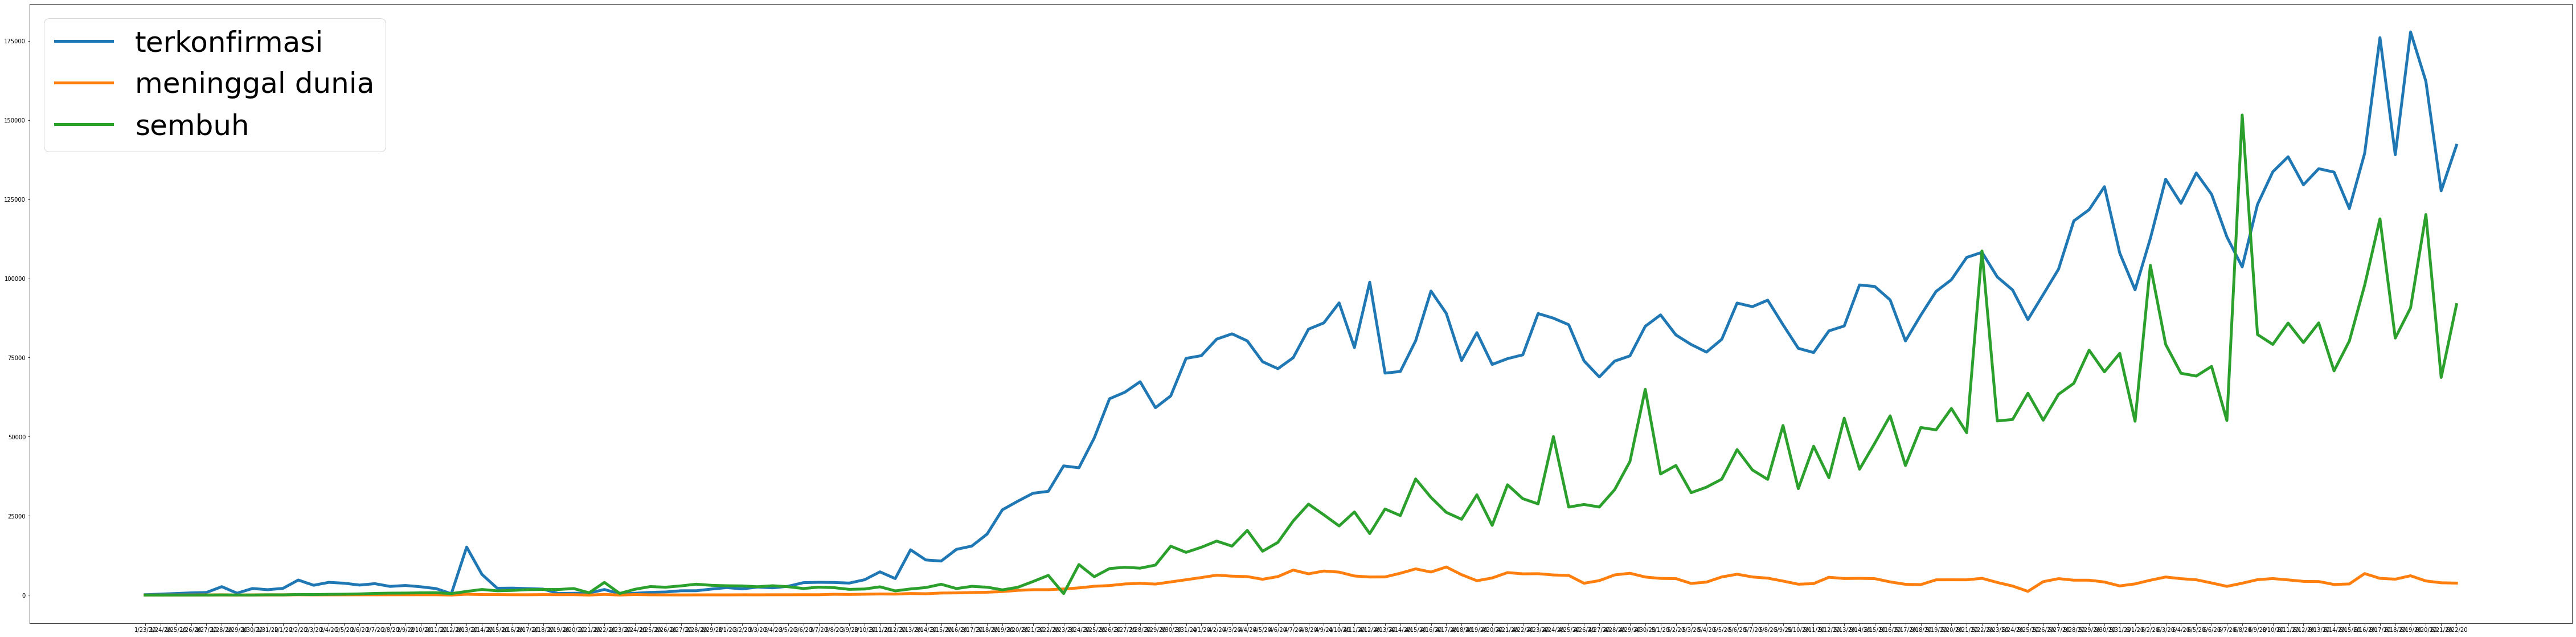

In [46]:
#GRAFIK PERKEMBANGAN COVID-19 DI DUNIA
import matplotlib.pyplot as plt

x=df_confirmed_daily.index
y1=df_confirmed_daily
y2=df_deaths_daily
y3=df_recovered_daily

fig = plt.figure(figsize= (80,20))
plt.plot(x,y1, label='terkonfirmasi', linewidth=5)
plt.plot(x,y2, label='meninggal dunia', linewidth=5)
plt.plot(x,y3, label='sembuh', linewidth=5)

plt.legend(loc=2, fontsize=50)
#plt.show()

In [47]:
df_deaths_t_stack

,Date,Countries,Deceased
0,2020-01-22,US,0.0
1,2020-01-22,Brazil,0.0
2,2020-01-22,United Kingdom,0.0
3,2020-01-22,Italy,0.0
4,2020-01-22,France,0.0
...,...,...,...
1525,2020-06-22,Spain,28324.0
1526,2020-06-22,Mexico,22584.0
1527,2020-06-22,India,14011.0
1528,2020-06-22,Iran,9742.0
